# CycleGAN: Human Faces to Anime Style
Model 1 of **Genshinfy-UwU**. This model is used for style-transfer based pairing in creating a dataset for training a siamese network (Model 2 of **Genshinfy-UwU**) to compare similarity between human and anime faces.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import matplotlib.pyplot as plt # plotting


import tensorflow as tf
import keras
from keras import layers, ops


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

os.environ["KERAS_BACKEND"] = "tensorflow"
autotune = tf.data.AUTOTUNE

## Creating a Custom Dataset

In [2]:
IMG_HEIGHT = 480
IMG_WIDTH = 480
BATCH_SIZE = 1

In [3]:
def load_image(path):
    image = tf.io.read_file(path)
    #if image.shape == ():
    #    print(f"Warning: Could not load image at {path}")
    #    return tf.zeros([IMG_HEIGHT, IMG_WIDTH, 3]) #return empty tensor
    image = tf.image.decode_jpeg(image, channels=3) #remove RGBA from GenshinImpact
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image / 127.5) - 1
    return image

In [4]:
def load_dataset(path):
    image_paths = tf.data.Dataset.list_files(
        os.path.join(path, '*'),
        shuffle=True
    )
    dataset = image_paths.map(
        load_image,
        num_parallel_calls=autotune
    )
    dataset = dataset.batch(BATCH_SIZE).prefetch(autotune)
    return dataset

In [5]:
AnimeFaces = load_dataset('/kaggle/input/animefacedataset/images')

In [6]:
CelebA = load_dataset('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba')

In [7]:
CycleDataset = tf.data.Dataset.zip((
    CelebA.shuffle(buffer_size=256).take(1024),
    AnimeFaces.shuffle(buffer_size=256).take(1024)
))

We can visualize some of the images in our dataset.

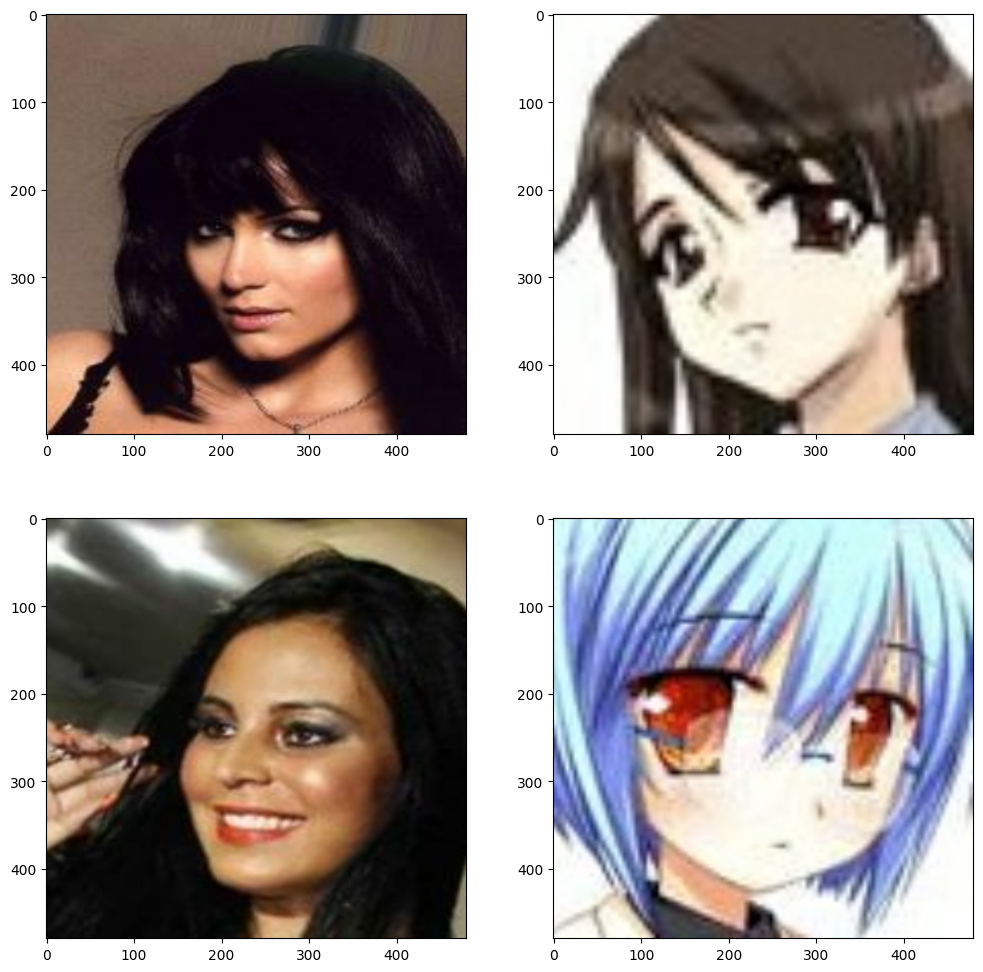

In [8]:
_, ax = plt.subplots(2, 2, figsize=(12, 12))
for i, samples in enumerate(CycleDataset.take(2)):
    real = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    fake = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(real)
    ax[i, 1].imshow(fake)
plt.show()

## Define Custom Layers

In [9]:
class ReflectionPadding2D(layers.Layer):
    def __init__(self, padding=(1,1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, inputs, mask=None):
        pad_width, pad_height = self.padding
        pad_tensor = [
            [0, 0],
            [pad_height, pad_height],
            [pad_width, pad_width],
            [0, 0]
        ]
        return ops.pad(inputs, pad_tensor, mode="REFLECT")

In [10]:
from keras.initializers import RandomNormal

KI = RandomNormal(mean=0.0, stddev=0.02)
GI = RandomNormal(mean=0.0, stddev=0.02)

In [11]:
def ResidualBlock(
    x,
    activation,
    kernel_initializer = KI,
    kernel_size = (3, 3),
    strides = (1, 1),
    padding = "valid",
    gamma_initializer = GI,
    use_bias = False
):
    dim = x.shape[-1]
    inputs = x
    x = ReflectionPadding2D()(inputs)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides = strides,
        kernel_initializer = kernel_initializer,
        padding = padding,
        use_bias = use_bias,
    )(x)
    x = layers.GroupNormalization(
        groups = 1,
        gamma_initializer = gamma_initializer,
    )(x)
    x = layers.add([inputs, x])
    return x

In [12]:
def DownSample(
    x,
    filters,
    activation,
    kernel_initializer = KI,
    kernel_size = (3, 3),
    strides = (2, 2),
    padding = "same",
    gamma_initializer = GI,
    use_bias = False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides = strides,
        kernel_initializer = kernel_initializer,
        padding = padding,
        use_bias = use_bias,
    )(x)
    x = layers.GroupNormalization(
        groups = 1,
        gamma_initializer = gamma_initializer,
    )(x)
    if activation: x = activation(x)
    return x

In [13]:
def UpSample(
    x,
    filters,
    activation,
    kernel_initializer = KI,
    kernel_size = (3, 3),
    strides = (2, 2),
    padding = "same",
    gamma_initializer = GI,
    use_bias = False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides = strides,
        kernel_initializer = kernel_initializer,
        padding = padding,
        use_bias = use_bias,
    )(x)
    x = layers.GroupNormalization(
        groups = 1,
        gamma_initializer = gamma_initializer,
    )(x)
    if activation: x = activation(x)
    return x

## Build a ResNet Model (CycleGAN Discriminator)

In [14]:
def ResNETGenerator(
    filters = 64,
    downsampling_blocks = 2,
    residual_blocks = 9,
    upsampling_blocks = 2,
    gamma_initializer = GI,
    name = "ResNETGenerator"
):
    image_input = layers.Input(shape=(480, 480, 3), name=name+"_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(image_input)
    x = layers.Conv2D(
        filters,
        (7, 7),
        kernel_initializer = KI,
        use_bias = False,
    )(x)
    x = layers.GroupNormalization(
        groups = 1,
        gamma_initializer = gamma_initializer,
    )(x)
    x = layers.Activation("relu")(x)

    # Downsample
    for _ in range(downsampling_blocks):
        filters *= 2
        x = DownSample(
            x,
            filters,
            activation = layers.Activation("relu")
        )

    # Residual Blocks
    for _ in range(residual_blocks):
        x = ResidualBlock(
            x,
            activation = layers.Activation("relu")
        )

    # Upsample
    for _ in range(upsampling_blocks):
        filters //= 2
        x = UpSample(
            x,
            filters,
            activation = layers.Activation("relu")
        )

    x = ReflectionPadding2D(padding=(3,3))(x)
    x = layers.Conv2D(
        3,
        (7, 7),
        padding = "valid",
    )(x)
    x = layers.Activation("tanh")(x)

    return keras.models.Model(image_input, x, name=name)

In [15]:
TestResNET = ResNETGenerator()
TestResNET.summary()

Model: "ResNETGenerator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ResNETGenerator_img_input │ (None, 480, 480, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reflection_padding2d      │ (None, 486, 486, 3)    │              0 │ ResNETGenerator_img_i… │
│ (ReflectionPadding2D)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 480, 480, 64)   │          9,408 │ reflection_padding2d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization       │ (None, 480, 480, 64)   │            128 │ conv2d[0][0]           │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 480, 480, 64)   │              0 │ group_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 240, 240, 128)  │         73,728 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_1     │ (None, 240, 240, 128)  │            256 │ conv2d_1[0][0]         │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 240, 240, 128)  │              0 │ group_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 120, 120, 256)  │        294,912 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_2     │ (None, 120, 120, 256)  │            512 │ conv2d_2[0][0]         │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 120, 120, 256)  │              0 │ group_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reflection_padding2d_1    │ (None, 122, 122, 256)  │              0 │ activation_2[0][0]     │
│ (ReflectionPadding2D)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 120, 120, 256)  │        589,824 │ reflection_padding2d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_3     │ (None, 120, 120, 256)  │            512 │ conv2d_3[0][0]         │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 120, 120, 256)  │              0 │ activation_2[0][0],    │
│                           │                        │                │ group_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reflection_padding2d_

 Total params: 6,070,403 (23.16 MB)

 Trainable params: 6,070,403 (23.16 MB)

 Non-trainable params: 0 (0.00 B)

## Build the CycleGAN Discriminator

In [16]:
def Discriminator(
    filters = 64,
    kernel_initializer = KI,
    downsampling = 3,
    name = "Discriminator",
):
    image_input = layers.Input(shape=(480,480,3), name=name+"_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(image_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for block in range(downsampling):
        num_filters *= 2
        if block < 2:
            x = DownSample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = DownSample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1,
        (4, 4),
        strides=(1, 1),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(x)

    return keras.models.Model(image_input, x, name=name)

In [17]:
TestDiscriminator = Discriminator()
TestDiscriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Discriminator_img_input (InputLayer) │ (None, 480, 480, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 240, 240, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 240, 240, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 120, 120, 128)       │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization_14               │ (None, 120, 120, 128)       │             256 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 120, 120, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 60, 60, 256)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization_15               │ (None, 60, 60, 256)         │             512 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 60, 60, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 60, 60, 512)         │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization_16               │ (None, 60, 60, 512)         │           1,024 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 60, 60, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 60, 60, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,765,633 (10.55 MB)

 Trainable params: 2,765,633 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

Get the Generators and Discriminators

In [18]:
# Get the generators
gen_G = ResNETGenerator(name="generator_G")
gen_F = ResNETGenerator(name="generator_F")

# Get the discriminators
disc_X = Discriminator(name="discriminator_X")
disc_Y = Discriminator(name="discriminator_Y")

## Build the CycleGAN
**Genshinfy-UwU Pipeline**    
The CycleGAN is to generate anime versions of human faces to serve as (human, anime) data pairs to the siamese network. This is because the siamese network is used for identifying the Genshin character most similar to the user's image. The style transfer model will then use these two images as input to Genshinfy the user.

In [19]:
tf.config.run_functions_eagerly(True)

In [20]:
class GenshinfySiameseDataGenerator(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle = 10.0,
        lambda_identity = 0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def call(self, inputs):
        return (
            self.disc_X(inputs),
            self.disc_Y(inputs),
            self.gen_G(inputs),
            self.gen_F(inputs),
        )

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, inputs):
        real_x, real_y = inputs # x is real, y is genshin
        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.gen_G(real_x, training=True)
            fake_x = self.gen_F(real_y, training=True)
            cycled_x = self.gen_F(fake_y, training=True)
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

**Callback:**
Periodically saves generated images.

In [21]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=2, save_interval=10):  # New parameter for interval
        self.num_img = num_img
        self.save_interval = save_interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_interval == 0:  # Only save every 20 epochs
            _, ax = plt.subplots(2, self.num_img, figsize=(12, 12))
            for i, img in enumerate(CelebA.shuffle(256).take(self.num_img)):
                prediction = self.model.gen_G(img)[0].numpy()
                prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
                img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

                ax[0, i].imshow(img)
                ax[1, i].imshow(prediction)
                ax[0, i].set_title("Input Image")
                ax[1, i].set_title("Translated Image")
                ax[0, i].axis("off")
                ax[1, i].axis("off")

                prediction = keras.utils.array_to_img(prediction)
                prediction.save(
                    "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
                )
            plt.show()
            plt.close()

## Train the Model

In [22]:
adv_loss_fn = keras.losses.MeanSquaredError()

In [23]:
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(ops.ones_like(fake), fake)
    return fake_loss

In [24]:
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(ops.ones_like(real), real)
    fake_loss = adv_loss_fn(ops.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

In [25]:
model = GenshinfySiameseDataGenerator(
    generator_G=gen_G,
    generator_F=gen_F,
    discriminator_X=disc_X,
    discriminator_Y=disc_Y
)

In [26]:
model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

In [27]:
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.weights.h5"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=True
)

In [ ]:
model.fit(
    CycleDataset.take(512),
    epochs=88,
    callbacks=[plotter, model_checkpoint_callback]
)

Epoch 1/88
512/512 ━━━━━━━━━━━━━━━━━━━━ 1152s 2s/step - D_X_loss: 0.1581 - D_Y_loss: 0.1578 - F_loss: 4.2775 - G_loss: 3.9079
Epoch 2/88
512/512 ━━━━━━━━━━━━━━━━━━━━ 1146s 2s/step - D_X_loss: 0.1727 - D_Y_loss: 0.1858 - F_loss: 3.0945 - G_loss: 2.8383
Epoch 3/88
512/512 ━━━━━━━━━━━━━━━━━━━━ 1137s 2s/step - D_X_loss: 0.1623 - D_Y_loss: 0.1759 - F_loss: 3.0353 - G_loss: 2.7915
Epoch 4/88
512/512 ━━━━━━━━━━━━━━━━━━━━ 1134s 2s/step - D_X_loss: 0.2081 - D_Y_loss: 0.1917 - F_loss: 2.7016 - G_loss: 2.6853
Epoch 5/88
512/512 ━━━━━━━━━━━━━━━━━━━━ 1130s 2s/step - D_X_loss: 0.2179 - D_Y_loss: 0.1863 - F_loss: 2.4096 - G_loss: 2.4898
Epoch 6/88
512/512 ━━━━━━━━━━━━━━━━━━━━ 1133s 2s/step - D_X_loss: 0.2153 - D_Y_loss: 0.1914 - F_loss: 2.4553 - G_loss: 2.3683
Epoch 7/88
512/512 ━━━━━━━━━━━━━━━━━━━━ 1133s 2s/step - D_X_loss: 0.2056 - D_Y_loss: 0.1875 - F_loss: 2.4432 - G_loss: 2.2950
Epoch 8/88
512/512 ━━━━━━━━━━━━━━━━━━━━ 1135s 2s/step - D_X_loss: 0.2158 - D_Y_loss: 0.1801 - F_loss: 2.3053 - G_loss: